In [1]:
import torch
import torchvision
import random
import string

import cv2 as cv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

from captcha.image import ImageCaptcha
from torch.utils.data import DataLoader, Dataset

### Static variables

In [2]:
# Model Location
PATH = './per_digit_model.pth'

include_lowercase = False

list_of_characters = string.ascii_uppercase + string.digits
if include_lowercase:
    list_of_characters += string.ascii_lowercase

# Data generation
num_of_loops = 1000
string_length = 5
image_width = 100 * string_length
image_height = 70
max_samples_per_char = int((num_of_loops * string_length) * 0.95)
standard_captcha = ImageCaptcha(width=image_width, height=image_height)

# Training variables
train_pct = 0.8


# Generating a CAPTCHAs to create a training dataset

In [3]:
generated_captchas = {}
for loop in range(num_of_loops):
    loop_str = f"{loop+1:02}"

    for char in list_of_characters:
        # Generate Captcha
        captcha_text = f"{char}  " * string_length
        captcha_image = standard_captcha.generate_image(captcha_text)
        solution = captcha_text.replace('  ', '')

        # Save the captcha in memory
        if generated_captchas.get(solution):
            generated_captchas[solution].append(captcha_image)
        else:
            generated_captchas[solution] = [captcha_image]

In [ ]:
def show_captchas(captchas: dict, number: int = 3):
    captcha_list = list(captchas.keys())
    for solution in captcha_list[:number]:
        plt.imshow(captchas[solution][0])
        plt.title(solution)
        plt.axis('off')
        plt.show()

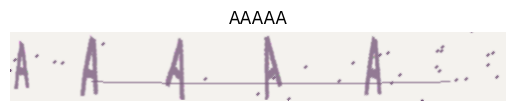

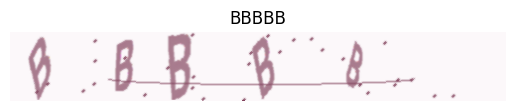

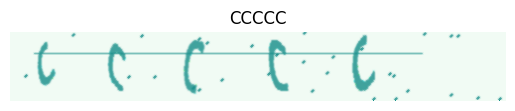

In [ ]:
show_captchas(generated_captchas, number=3)

# Denoising and Splitting
Separate the 5 same string captchas into individual digits and denoise them to create our final training dataset.

### First denoising

In [ ]:
def denoise_captcha(captchas: dict):
    processed_captchas = {}

    for solution in list(captchas.keys()):
        for captcha in captchas[solution]:
            # Convert to grayscale then B/W
            img = cv.cvtColor(np.array(captcha), cv.COLOR_BGR2GRAY)
            _, binarized = cv.threshold(img, 230, 255, cv.THRESH_BINARY_INV)

            # Remove pixels with erosion to weaken noise
            kernel = np.ones((3, 3), np.uint8)
            eroded = cv.erode(binarized, kernel, iterations=1)

            # Remove pixels with a median filter to weaken vertical and horizontal lines
            median_filtered = cv.medianBlur(eroded, 3)
            horizontal_kernel = np.ones((1, 5), np.uint8)
            horizontal_filtered = cv.morphologyEx(median_filtered, cv.MORPH_CLOSE, horizontal_kernel)

            # Add pixels with dilation to thicken letters and digits
            dilation_kernel = np.ones((3, 3), np.uint8)
            dilated = cv.dilate(horizontal_filtered, dilation_kernel, iterations=1)

            # Remove pixels with a median filter again for good measure
            result = cv.medianBlur(dilated, 3)

            # Save result in memory
            if processed_captchas.get(solution):
                processed_captchas[solution].append(result)
            else:
                processed_captchas[solution] = [result]
                
    return processed_captchas

A sample of the denoised data

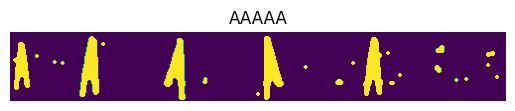

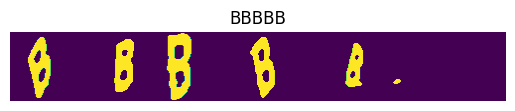

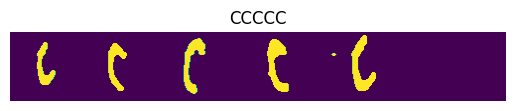

In [ ]:
processed_captchas = denoise_captcha(generated_captchas)
show_captchas(processed_captchas, number=3)

### Prepare for separation

In [ ]:
def preprocess_captchas(captchas: dict):
    final_captchas = {}
    for solution in list(captchas.keys()):
        for captcha in captchas[solution]:
            contours, _ = cv.findContours(captcha, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
            filtered_contours = [
                contour for contour in contours if cv.contourArea(contour) > 100
            ]
            
            # Sort contours from left to right and only keep the specified number
            filtered_contours = sorted(filtered_contours, key=lambda contour: cv.boundingRect(contour)[0])
            num_contours = min(len(filtered_contours), string_length)
            
            # Initialize a black background for the output
            segmented_canvas = np.zeros((50, 50 * num_contours), dtype=np.uint8)
            
            for i, contour in enumerate(filtered_contours[:num_contours]):
                x, y, w, h = cv.boundingRect(contour)
                
                # Calculate the aspect ratio
                aspect_ratio = w / h
                
                # Calculate new width and height to maintain aspect ratio within 50x50 canvas
                new_width = min(50, int(aspect_ratio * 50))
                new_height = min(50, int(50 / aspect_ratio))
                
                # Resize the character to the calculated size and place on the black background
                character = captcha[y: y+h, x: x+w]
                resized_character = cv.resize(character, (new_width, new_height))
                x_offset = (50 - new_width) // 2
                y_offset = (50 - new_height) // 2
                segmented_canvas[y_offset: y_offset+new_height, i * 50 + x_offset : i * 50 + x_offset + new_width] = resized_character

            # Save result in memory
            if final_captchas.get(solution):
                final_captchas[solution].append(segmented_canvas)
            else:
                final_captchas[solution] = [segmented_canvas]

    return final_captchas

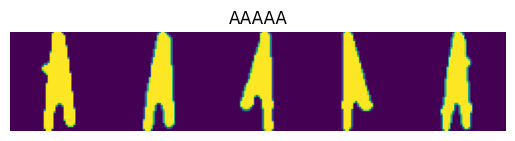

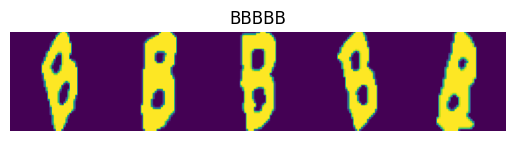

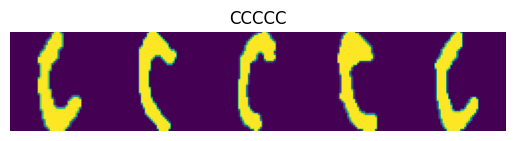

In [ ]:
final_captchas = preprocess_captchas(processed_captchas)
show_captchas(final_captchas, number=3)

Split data for our final dataset

In [ ]:
def split_captchas(captchas: dict):
    dataset = {}
    for solution in list(captchas.keys()):
        for captcha in captchas[solution]:
            sub_images = [captcha[:, i * 50 : (i + 1) * 50] for i in range(captcha.shape[1] // 50)]
            char = solution[0]

            if len(dataset.get(char, [])) >= max_samples_per_char:
                continue

            for img in sub_images:
                if len(dataset.get(char, [])) >= max_samples_per_char:
                    break

                if dataset.get(char):
                    dataset[char].append(img)
                else:
                    dataset[char] = [img]

    return dataset

In [ ]:
dataset = split_captchas(final_captchas)

Visualize a small sample of the training data

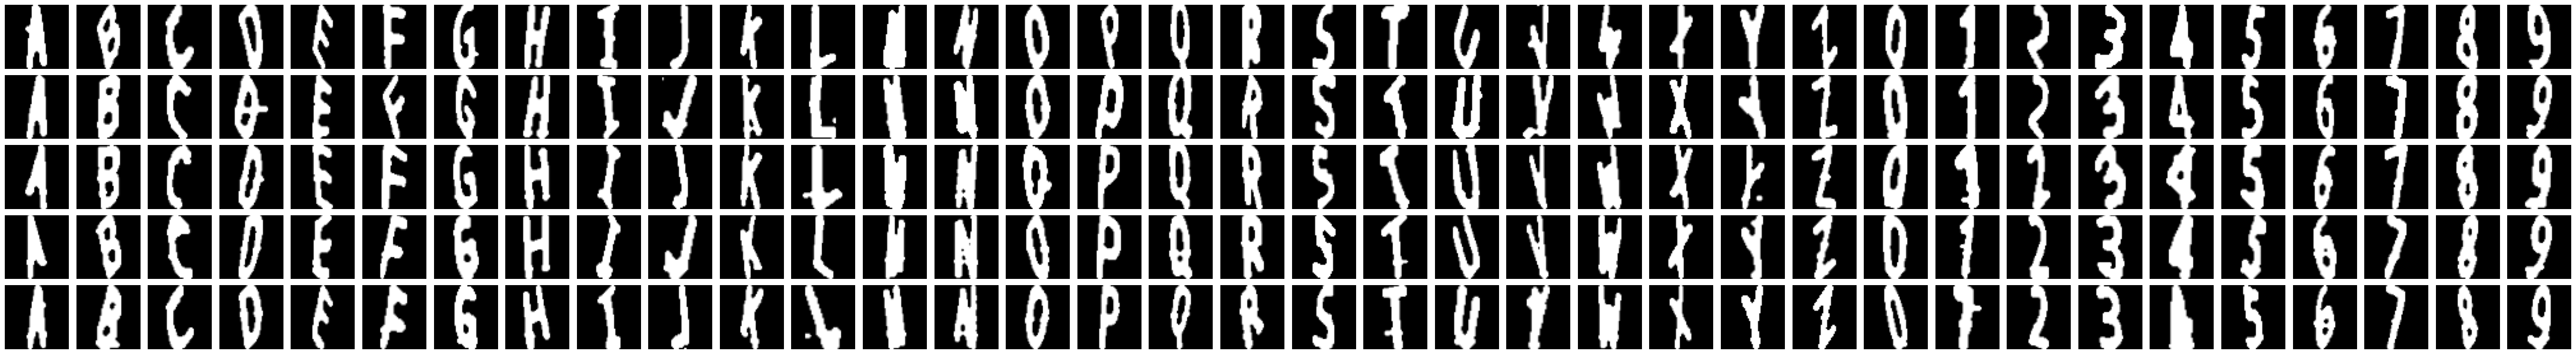

In [ ]:
num_rows = 5
num_columns = len(dataset.keys())
fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 1.5, num_rows * 1.5))

for col_idx, (character, images) in enumerate(dataset.items()):
    for row_idx, image in enumerate(images[:num_rows]):
        ax = axes[row_idx, col_idx]
        ax.imshow(image, cmap='gray')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def get_class_name(class_index: int):
    return list(dataset.keys())[class_index]

def get_class_index(class_name: str):
    return list(dataset.keys()).index(class_name)
    
number_of_classes = len(dataset.keys())
classes = {
    get_class_name(x) : x for x in range(number_of_classes)
}

### Finalizing the dataset

In [ ]:
class GeneratedDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(np.array(image))
        
        return image, label

data_transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.5,), (0.5,))
    ]
)

# Train/test Split
train_labels = []
test_labels = []
train_data = []
test_data = []

for char, images in dataset.items():
    random.shuffle(images)
    cut = int(train_pct * len(images))
    train_data += images[:cut]
    test_data += images[cut:]
    train_labels.append([get_class_index(char) for _ in range(len(images[:cut]))])
    test_labels.append([get_class_index(char) for _ in range(len(images[cut:]))])

train_labels = np.array(train_labels).flatten()
test_labels = np.array(test_labels).flatten()

train_dataset = GeneratedDataset(
    torch.FloatTensor(train_data),
    torch.LongTensor(train_labels),
    transform=data_transform
)

test_dataset = GeneratedDataset(
    torch.FloatTensor(test_data),
    torch.LongTensor(test_labels),
    transform=data_transform
)

## CNN Definition

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 36)
        self.fc3 = nn.Linear(36, number_of_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training the network

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
for epoch in range(25):

    net.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    net.eval()
    with torch.no_grad():
        loss = 0.0
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Epoch {epoch + 1} - Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")

print('Finished Training')

Epoch 1 - Loss: 0.4136 - Accuracy: 0.8928
Epoch 2 - Loss: 0.1322 - Accuracy: 0.9094
Epoch 3 - Loss: 0.3195 - Accuracy: 0.9186
Epoch 4 - Loss: 0.0490 - Accuracy: 0.9356
Epoch 5 - Loss: 0.0112 - Accuracy: 0.9442
Finished Training


### Saving trained network

In [ ]:
torch.save(net.state_dict(), PATH)

### Loading trained network

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Testing the network

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TrueLabel:  d e n k f R 7 V z B w V R 0 7 f B E I V Z z G V X n b V m n C y
Predicted:  d e n k f R 7 V z B w V R 0 7 f B E I V Z z G V X n b V m n C y


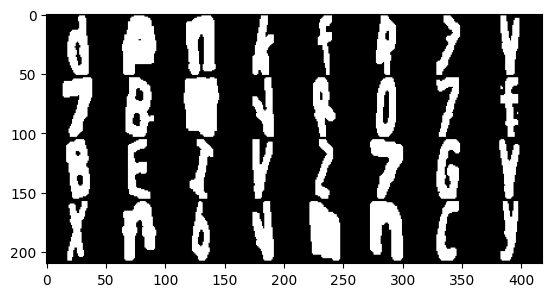

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(images).numpy(), (1, 2, 0)
    )
)
print('TrueLabel: ', ' '.join(get_class_name(label) for label in labels))

outputs = net(images)
_, predicted_labels = torch.max(outputs, 1)

print('Predicted: ', ' '.join(get_class_name(label) for label in predicted_labels))

### Per class prediction

In [ ]:
correct_pred = {classname: 0 for classname in classes.keys()}
total_pred = {classname: 0 for classname in classes.keys()}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[get_class_name(label)] += 1
            total_pred[get_class_name(label)] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: A     is 94.0 %
Accuracy for class: B     is 98.0 %
Accuracy for class: C     is 99.0 %
Accuracy for class: D     is 91.0 %
Accuracy for class: E     is 99.0 %
Accuracy for class: F     is 97.0 %
Accuracy for class: G     is 96.0 %
Accuracy for class: H     is 97.0 %
Accuracy for class: I     is 94.0 %
Accuracy for class: J     is 98.0 %
Accuracy for class: K     is 93.0 %
Accuracy for class: L     is 96.0 %
Accuracy for class: M     is 97.0 %
Accuracy for class: N     is 98.0 %
Accuracy for class: O     is 36.0 %
Accuracy for class: P     is 92.0 %
Accuracy for class: Q     is 97.0 %
Accuracy for class: R     is 95.0 %
Accuracy for class: S     is 100.0 %
Accuracy for class: T     is 97.0 %
Accuracy for class: U     is 96.0 %
Accuracy for class: V     is 97.0 %
Accuracy for class: W     is 97.0 %
Accuracy for class: X     is 93.0 %
Accuracy for class: Y     is 96.0 %
Accuracy for class: Z     is 95.0 %
Accuracy for class: 0     is 80.0 %
Accuracy for class: 1     i

## Getting random CAPTCHA

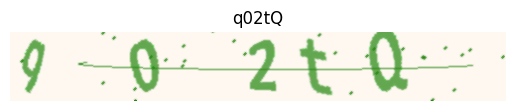

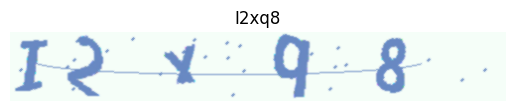

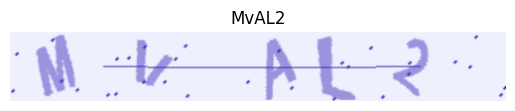

In [ ]:
def get_random_captcha(length: int = 5):
    captcha_char_string = ' '.join(random.choice(list_of_characters) for _ in range(length))
    solution = captcha_char_string.replace(" ", "")

    image_width = 100 * length
    image_height = 70

    captcha = ImageCaptcha(width=image_width, height=image_height)
    captcha_image = captcha.generate_image(captcha_char_string)

    return captcha_image, solution

for _ in range(3):
    captcha, solution = get_random_captcha()
    plt.imshow(captcha)
    plt.axis('off')
    plt.title(solution)
    plt.show()

## Pre-processing and predicting generated CAPTCHA

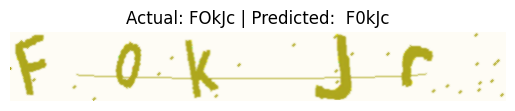

In [ ]:
captcha, solution = get_random_captcha()
captcha_dict = {solution: [captcha]}

denoised = denoise_captcha(captcha_dict)
processed = preprocess_captchas(denoised)
split = split_captchas(processed)
with torch.no_grad():
    digits = []

    for digit in list(split.values())[0]:
        new_digit = digit[np.newaxis, :, :]
        digits.append(new_digit)

    digits = torch.Tensor(np.array(digits))
    prediction = []
    outputs = net(digits)
    _, predicted = torch.max(outputs.data, 1)
    predicted = ''.join(get_class_name(label) for label in predicted)

plt.imshow(captcha)
plt.axis("off")
plt.title(f"Actual: {solution} | Predicted:  {predicted}")
plt.show()

# Evaluating performance over X number of CAPTCHAs

In [ ]:
correct = 0
number_of_captchas = 10_000
for _ in range(number_of_captchas):
    captcha, solution = get_random_captcha()
    captcha_dict = {solution: [captcha]}

    denoised = denoise_captcha(captcha_dict)
    processed = preprocess_captchas(denoised)
    split = split_captchas(processed)
    with torch.no_grad():
        digits = []

        for digit in list(split.values())[0]:
            new_digit = digit[np.newaxis, :, :]
            digits.append(new_digit)

        digits = torch.Tensor(np.array(digits))
        prediction = []
        outputs = net(digits)
        _, predicted = torch.max(outputs.data, 1)
        predicted = ''.join(get_class_name(label) for label in predicted)
    
    if predicted.upper() == solution.upper():
        correct += 1

print(f"Total: {number_of_captchas}. Correct: {correct}. Accuracy {correct/number_of_captchas:4f}")

Total: 10000. Correct: 2274. Accuracy 0.227400
